# 1) Conversion of music file to DNA fasta file

### 1.1) Conversion of sounds to frequencies to notes

Information about song

In [1]:
songname = 'SuperMario'
year = '1989'
genre = 'Pop'

load packages

In [2]:
import sys
import statistics
import subprocess
import random

freq_to_letter_dict = {}
time_note = {}

Pull in .wav file to aubio

In [3]:
filename = 'SuperMario.wav '
aubio_output = subprocess.check_output('aubiopitch '+ filename, shell = True)
aubio_output = aubio_output.decode('utf-8')


Split aubio list on newlines to make it readable

In [4]:
aubio_list = aubio_output.split("\n")

Make a dictionary for duration and frequency of notes in music

In [5]:
freq_dict = {}
for line in aubio_list:
	line_split = line.split()
	if len(line_split) !=2:
		#print('Messed up',line)
		continue
	time = float(line_split[0])
	frequency = float(line_split[1])
	freq_dict[time] = frequency

opening the reference musical-note-to-frequency file

In [6]:
with open('freq_note.txt','r') as file_obj2:
	for line in file_obj2:
                min_max_dict = {}		#Open a sub-dictionary for each note
                line = line.rstrip()
                line_split = line.split()
                note = line_split[0]
                frequency_min =float(line_split[1])	#Take the minimum frequency
                frequency_max = float(line_split[2])	#Take the maximum frequency
                min_max_dict["mini"]=frequency_min	#Append the max/min frequency into the dictionary as a sub-dictionary
                min_max_dict["maxi"]=frequency_max
                freq_to_letter_dict[note] = min_max_dict            #Makes a dictionary with form {note:{min,max}}

Loop through the notes in the reference dictionary

In [7]:
for note in freq_to_letter_dict:
    for minimum in freq_to_letter_dict[note]:    
        mini = freq_to_letter_dict[note]["mini"]
        maxi = freq_to_letter_dict[note]["maxi"]
        for time in freq_dict:					   #For each duration, assign a note based on frequency
            if mini<=freq_dict[time] and freq_dict[time] < maxi:   #If frequency between min/max of a note, assign that note
                time_note[time] = note   			   #Make a new dictionary of form {duration:note}
        else:
            continue						   #If it doesn't match the frequency, look thru more notes

Assigning variables for the duration into consideration

In [8]:
start = 0
start_time=0
end_time=0
start_note = ''
end_note = ''

el_listerino = []

For each time in the sorted duration:note dictionary check if long or short

In [9]:
for time in sorted(time_note, key=float):
    start = time
    note = time_note[time]
    if start_time == 0:			#For the very first note in the song
        start_time = start		#Reset all variables to this baseline note
        start_note = note
        end_time = time
    else:    				#If not first note
        if note == start_note:		#but if same as the last note played
            end_time = time		#increase the end time
        else:         			#If it is a different note than last played
            tiny_list = []			#Make a list every time to create a list of lists later - to keep order
            tiny_list.append(float(end_time) - float(start_time))	#calculate the duration of a note (end-start)
            tiny_list.append(start_note)				#for each, create the [duration,note] list
            el_listerino.append(tiny_list)				#append [duration,note] list into the bigger one
            start_note = note			#Reset all variables 
            start_time = time
            end_time = time

In [10]:
duration_list = []			 
for duration in el_listerino:			#To calculate the median, we need to make another list
    duration_list.append(duration[0])

least = min(duration_list)			#Least and most were used to sanity check the median
most = max(duration_list)
middle = statistics.median(duration_list)


notes_list = []				#The final countdown
for line in el_listerino:
	note, extra  = line[1].split("_")	#In the ref, the notes have "_" appended. Split here into proper notation
	duration = line[0]			
	if duration > middle:			#If the duration is longer than the median, consider it a whole note
		if note.endswith("3"):
			note = note.replace("3","4")	#Change from reference notation into next script's notation
			notes_list.append(note)
		else:				#If the duration is shorter or equal to the median, consider half note
			note = note+"2"		#Change from reference notation into the next script's notation
			notes_list.append(note)
	else:
		notes_list.append(note)	#This is the same notation as the next script, so leave


final_notes_list = []				
for note in notes_list:
	if note == "R":				#Change rest into the next scipt's notation
		note = " "
		final_notes_list.append(note)
	elif note == "R2":			#Change long rest into the next script's notation
		note = " 2"
		final_notes_list.append(note)
	else:
		final_notes_list.append(note)	#If not a rest, leave it

### 1.2) Conversion of notes to nucleotides

Notes Dictionary: Notes/Keys are assigned a numeric value. The '2' version of each key is designated as the half note

In [11]:
key_dict = {'C':'1', 'C2':'2', 'C#':'3', 'Db':'3', 'C#2':'4', 'Db2':'4', 'D':'5', 'D2':'6', 'D#':'7', 'Eb':'7', 'D#2':'8', 'Eb2':'8', 'E':'9', 'E2': '10', 'F':'11', 'F2':'12', 'F#':'13', 'Gb':'13', 'F#2':'14', 'Gb2':'14', 'G':'15', 'G2':'16', 'G#':'17', 'Ab':'17', 'G#2':'18', 'Ab2':'18', 'A':'19', 'A2':'20', 'A#':'21', 'Bb':'21', 'A#2':'22', 'Bb2':'22', 'B':'23', 'B2':'24', 'C3':'25', 'C4':'26', 'C#3':'27', 'Db3':'27', 'C#4':'28', 'Db4':'28', 'D3':'29', 'D4':'30', 'D#3':'31', 'Eb3':'31', 'D#4':'32', 'Eb4':'32', 'E3':'33', 'E4':'34', 'F3':'35', 'F4':'36', 'F#3':'37', 'Gb3':'37', 'F#4':'38', 'Gb4':'38', 'G3':'39', 'G4':'40', ' ':'41', ' 2':'42'}

Conversion of notes to amino acids: This dictionary accounts for amino acid frequency: Most frequent AA is on the white keys. 

In [12]:
key_to_codon_dict = {'1':['R1', 'R2', 'R3'], '2':['R4', 'R5', 'R6'], '3':['F1'], '4':['F2'], '5':['N1'], '6':['N2'], '7':['P1', 'P2'], '8':['P3', 'P4'], '9':['D1'], '10':['D2'], '11':['C1'], '12':['C2'], '13':['S1', 'S2', 'S3'], '14':['S4', 'S5', 'S6'], '15':['Q1'], '16':['Q2'], '17':['T1', 'T2'], '18':['T3', 'T4'], '19':['E1'], '20':['E2'], '21':['W'], '22':['W'], '23':['G1', 'G2'], '24':['G3', 'G4'], '25':['H1'], '26':['H2'], '27':['Y1'], '28':['Y2'], '29':['I1', 'I2'], '30':['I3'], '31':['V1', 'V2'], '32':['V3', 'V4'], '33':['L1', 'L2', 'L3'], '34':['L4', 'L5', 'L6'], '35':['K1'], '36':['K2'], '37':['Z1', 'Z2'], '38':['Z3'], '39':['M'], '40':['M'], '41':['A1', 'A2'], '42':['A3', 'A4']}

Conversion of amino acids to nucleotide triplets: stop codon was assigned Z

In [13]:
codon_to_nt_dict = {'F1':'TTT', 'F2':'TTC', 'L1':'TTA', 'L2':'TTG', 'L3':'CTT', 'L4':'CTC', 'L5':'CTA', 'L6':'CTG', 'I1':'ATT', 'I2':'ATC', 'I3': 'ATA', 'M': 'ATG', 'V1': 'GTT', 'V2':'GTC', 'V3':'GTA', 'V4':'GTG', 'S1':'TCT', 'S2':'TCC', 'S3':'TCA', 'S4':'TCG', 'S5':'AGT', 'S6':'AGC', 'P1':'CCT', 'P2':'CCC', 'P3':'CCA', 'P4':'CCG', 'T1':'ACT', 'T2':'ACC', 'T3':'ACA', 'T4':'ACG', 'A1':'GCT', 'A2':'GCC', 'A3':'GCA', 'A4':'GCG', 'Y1':'TAT', 'Y2': 'TAC', 'Z1':'TAA', 'Z2':'TAG', 'Z3':'TGA', 'H1':'CAT', 'H2':'CAC', 'Q1':'CAA', 'Q2':'CAG', 'N1':'AAT', 'N2':'AAC', 'K1':'AAA', 'K2':'AAG', 'D1':'GAT', 'D2':'GAC', 'E1':'GAA', 'E2':'GAG', 'C1':'TGT', 'C2':'TGC', 'W':'TGG', 'R1':'CGT', 'R2':'CGC', 'R3':'CGA', 'R4':'CGG', 'R5':'AGA', 'R6':'AGG', 'G1':'GGT', 'G2':'GGC', 'G3':'GGA', 'G4':'GGG'}

Function to convert a song input into nucleotide sequence

In [14]:
import random

numbers =[]
note_to_codons = []
for note in final_notes_list:
    number = key_dict[note]
    numbers.append(number)

for num in numbers:
    codons = key_to_codon_dict[num]
    if len(codons) ==1:
        associated_codon = key_to_codon_dict[num][0]
        note_to_codons.append(associated_codon)
    elif len(codons) >1:
        random_number = int(random.randrange(0, len(codons)))
        associated_codon = key_to_codon_dict[num][random_number]
        note_to_codons.append(associated_codon)
#print(note_to_codons)

sequence1 = ''
for aa in note_to_codons:
    nt = codon_to_nt_dict[aa]
    sequence1+=nt

GCGCAGGCGCAAGCCGACGCAGATTTTCGCAGGGCTCGTACTTGCCAGTCCTGCGACTTTAGGGACTGCCCTAATCCTGACTTTAGAGAAGGCCAGGACTTTCGAAGAGGCTGCCAGTCTTGCGACCCTAGAGACTGCCCCAATCCCGACTTTAGAGAAGGCCAGGCTCAA


Make a fasta file containing nucleotide sequence

In [19]:
fasta_file = '>' + songname + '\t' + year + '\t' + genre + '\n' + sequence1
open_fasta = open('fasta_file.fasta','w')
open_fasta.write(fasta_file)

>SuperMario	1989	Pop
GCGCAGGCGCAAGCCGACGCAGATTTTCGCAGGGCTCGTACTTGCCAGTCCTGCGACTTTAGGGACTGCCCTAATCCTGACTTTAGAGAAGGCCAGGACTTTCGAAGAGGCTGCCAGTCTTGCGACCCTAGAGACTGCCCCAATCCCGACTTTAGAGAAGGCCAGGCTCAA


192

# 2) Blasting of DNA 

Import Packages

In [20]:
import time
import os
import re
from Bio import SearchIO
import webbrowser
from fpdf import FPDF
from IPython.display import Image

Run Blast from command line

In [24]:
cmd = "blastn -query fasta_file.fasta -task 'blastn-short' -max_hsps 1 -db final_all_cds.fna -out test6.txt"
os.system(cmd)

0

Open and parse Blast file 

In [25]:
filename = 'test6.txt' #we will have the general output from the blast be blastoutput.txt that way it is easy to bring in

for QueryResult in SearchIO.parse(filename, 'blast-text'):#parses the query name
    print('Query name:',QueryResult.id)#prints the query name
    print('Query length:',QueryResult.seq_len)
query_name = 'Query name: '+str(QueryResult.id)
query_length = 'Query length: '+str(QueryResult.seq_len)

for Hit in SearchIO.read(filename, 'blast-text'):#prints out the top hit id and description
    top_hit = Hit.description
    #print(top_hit)
    for found in re.finditer(r'(^\S?.+)\s(\[gene=)(\w+.?\w)',top_hit):
        organism = found.group(1)
        gene = found.group(3)
    break
else:
    print("no hits")
    organism = "no match organism"
    gene = "no match gene"

print('Organism:',organism)
hit_organism = 'Organism: '+str(organism)
print('Gene:',gene)
hit_gene = 'Gene: '+str(gene)

for alignment in SearchIO.read(filename, 'blast-text'):
        for hsp in alignment.hsps:#prints out the hsp evalue score
                evalue = 'E-value: '+str(hsp.evalue)
                print('E-value:',hsp.evalue)
                hit_start = 'Hit start: '+str(hsp.hit_start)
                print('Hit start:', hsp.hit_start)
                hit_end = 'Hit end:'+str(hsp.hit_end)
                print('Hit end: ', hsp.hit_end)
                hit_identity = 'Nucleotide match: '+str(hsp.ident_num)
                print('Nucleotide match: ',hsp.ident_num)
        break
else:
    print("no evalue")
    evalue = "no evalue"

Query name: SuperMario
Query length: 171
Organism: Vitis vinifera
Gene: LOC100259870
E-value: 3.8
Hit start: 1005
Hit end:  1022
Nucleotide match:  17


Create output file from Blast search

In [26]:
chlamydia = "    ,---. \n   / . . \ \n   |  _  | \n    \     /  \n    '___'  "
#print(chlamydia)

grapes = "    \-\       \n   __\ \ ,--.  \n  (``)\ \(  )-,  \n ( `` )(```)   ) \n  `--',.`-'(```) \n  (   X    )`-`,  \n   `-` `--`(   )  \n       (   )`-`,  \n        `-`(   ) \n            `-`   "

cat = "                         _\n                        / )\n                       ( (\n       A.-.A   .-''-.   ) )\n     / , , \_/        \\/ /\n     \ =t= ;       /    /\n      `--,\'  .__.|     /\n          || |    \\\\  | \n         ((,_|    ((,_\\"

c_elegans = "    ____\n   /    \ \n  '_,-,  \ \n      /   |\n     /   /\n    |   |     __    /\\\n    (    \___/  \___| |\n     \         _      /\n      \_______/ \____/"

mouse = "  (\__/)   \n /O O `.  \n   {O__,   \    {\n       / .  . )    \ \n       |-| '-' \    } \n      .(   _(   )_.'  \n  '---.~_ _ _&  "

fish = "       o                 o\n                  o    \n         o   ______      o \n           _/  (   \_  \n _       _/  (       \_  O  \n| \_   _/  (   (    0  \  \n|== \_/  (   (          | \n|=== _ (   (   (        |\n|==_/ \_ (   (          |\n|_/     \_ (   (    \__/\n          \_ (      _/\n            |  |___/\n           /__/"

sadness = "No match organism, no picture for you"

if organism == "Chlamydia abortus":
    picture = chlamydia
    red =255
    green =102
    blue =175
    alignment = "C"
elif organism == "Felis_catus":
    picture = cat
    red = 255
    green =153
    blue =51
    alignment = "C"
elif organism == "Caenorhabditis elegans":
    picture = c_elegans
    red = 204
    green =204
    blue =0
    alignment = "L"
elif organism == "Vitis vinifera":
    picture = grapes
    red = 127
    green = 0
    blue = 255
    alignment = "L"
elif organism == "Danio rerio":
    picture = fish
    red =51
    green =153
    blue =255
    alignment = "L"
elif organism == "Mus musculus":
    picture = mouse
    red =160
    green = 160
    blue = 160
    alignment = "C"
else:
    picture = sadness
    red =255
    green =0
    blue =0
    alignment = "L"

pdf = FPDF()
pdf.add_page()
pdf.set_font('Courier',size=24)
pdf.cell(100,20, txt = query_name, ln=1, align="L")
pdf.cell(100,20, txt = query_length, ln=1, align="L")
pdf.cell(100,20, txt = hit_organism, ln=1, align="L")
pdf.cell(100,20, txt = hit_gene, ln=1, align="L")
pdf.cell(100,20, txt = evalue, ln=1, align="L")
pdf.set_text_color(int(red),int(green),int(blue))
pdf.multi_cell(200,10, txt = picture, align=alignment)


ts = str(int(time.time()))
blast_dir = '/var/www/html/blast_pdfs'
blast_filename = blast_dir + "/Blast_visualization" + ts + ".pdf"
pdf.output(blast_filename)

test = "http://djmm.programmingforbiology.org/blast_pdfs/Blast_visualization" + ts + ".pdf"

from IPython.display import IFrame
IFrame(test, width=600, height=700)

#

#print("Your run is complete; please see PDF!")

# 3) PCA to determine organism that music might relate to

### 3.1) Dictionaries containing counts of nt and aa   

Creation of fasta file with header containing song name, organism (from Blast), year song was released and genre of song

In [108]:
music_to_fasta = '>' + songname + '\t' + songname +'\t' + year + '\t' + genre + '\n' + sequence1 + '\n'
file = open('/projects/djmm/spa/music_to_DNA.fasta', 'w')

file.write(music_to_fasta)

>SuperMario	SuperMario	1938	Dance
GCGCAGGCGCAAGCCGACGCAGATTTTCGCAGGGCTCGTACTTGCCAGTCCTGCGACTTTAGGGACTGCCCTAATCCTGACTTTAGAGAAGGCCAGGACTTTCGAAGAGGCTGCCAGTCTTGCGACCCTAGAGACTGCCCCAATCCCGACTTTAGAGAAGGCCAGGCTCAA



206

Reference fasta file

Combine fasta files with reference fasta file

In [111]:
! cat music_to_DNA.fasta DNA_sequences_from_organism_for_PCAplot.fasta > combined.fasta

Opening of fasta file input and creation of dictionaries 

In [112]:
#import sys

#fasta_sequence = sys.argv[1]
#open_fasta_sequence = open (fasta_sequence , "r")

open_fasta_sequence = open('/projects/djmm/spa/combined.fasta', "r")

nucleotide_dict = {}
nucleotide_comp = {}
amino_acid_comp ={}
seq_id = ''
final_dict ={}

Dictionary with nucleotide counts

In [113]:
import re

for line in open_fasta_sequence:
    line = line.rstrip()
    if line.startswith('>'):
        for (seq_id, organism, year, genre) in re.findall(r'>(\S+)\s(\w+\s?\w+)\s(\d+)\s(\w+)', line):
            nucleotide_dict[seq_id] = ''
    else:
        if seq_id in nucleotide_dict:
            nucleotide_dict[seq_id] += line
        else:
            nucleotide_dict[seq_id] = line
#print(nucleotide_dict)
#create a dictioary with nucleotide count
for seq_id in nucleotide_dict:
    sequence = nucleotide_dict[seq_id]
    a_count = sequence.count('A')
    c_count = sequence.count('C')
    g_count = sequence.count('G')
    t_count = sequence.count('T')
    nucleotide_comp[seq_id] = {'nucA':a_count,'nucC':c_count,'nucG':g_count,'nucT':t_count}

Dictinoary with amino acid composition

In [114]:
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis

for seq_id in nucleotide_dict:
    sequence = nucleotide_dict[seq_id]
    seqobj = Seq(sequence)
    seq_str=str(seqobj)
    protein = seqobj.translate()
    prot_str = str(protein)
    amino_acid_comp[seq_id] = prot_str

for seq_id in amino_acid_comp:
    prot_str = amino_acid_comp[seq_id]
    prot_obj = ProteinAnalysis(prot_str)
    count_aa = prot_obj.count_amino_acids()
    amino_acid_comp[seq_id] = count_aa

/usr/local/anaconda/lib/python3.7/site-packages/Bio/Seq.py:2576: BiopythonWarning:

Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.



Dictionary with organism name

In [115]:
open_fasta_sequence = open('/projects/djmm/spa/combined.fasta', "r")

organism_dict = {}

for line in open_fasta_sequence:
    line = line.rstrip()
    if line.startswith('>'):
        for (seq_id, organism, year, genre) in re.findall(r'>(\S+)\s(\w+\s?\w+)\s(\d+)\s(\w+)', line):
            organism_dict[seq_id] = organism

{'SuperMario': 'SuperMario', 'unc119a': 'Danio rerio', 'unc119b': 'Danio rerio', 'unc119c': 'Danio rerio', 'bmp2a': 'Mus musculus', 'bmp3': 'Mus musculus', 'bmp4': 'Mus musculus', 'srh-1': 'Caenorhabditis elegans', 'srh-4': 'Caenorhabditis elegans', 'srh-7': 'Caenorhabditis elegans', 'rab2a': 'Felis_catus', 'rab2b': 'Felis_catus', 'rab4': 'Felis_catus', 'auxin1': 'Vitis vinifera', 'auxin2': 'Vitis vinifera', 'auxin3': 'Vitis vinifera', 'ileS': 'Chlamydia abortus', 'serS': 'Chlamydia abortus', 'proS': 'Chlamydia abortus'}


### 3.2) Dataframes containing nt and aa counts and organism of DNA strings

In [116]:
import pandas as pd
import numpy as np

aa_df = pd.DataFrame.from_dict(amino_acid_comp)
print(aa_df)
nt_df = pd.DataFrame.from_dict(nucleotide_comp)
organism_df = pd.Series(organism_dict).to_frame().transpose()
organism_df = organism_df.rename({0: 'organism'}, axis='index')

seq_df = pd.concat([aa_df, nt_df, organism_df]).transpose()

   SuperMario  unc119a  unc119b  unc119c  bmp2a  bmp3  bmp4  srh-1  srh-4  \
A           6        7        9        3     11     9     8      2      2   
C           6        2        2        1      1     2     1      8     12   
D           9        3        5        2      4     4     3      2      5   
E           2        4        5        4      6     3    13      2      7   
F           5        5        2        3      4     2     3     10      8   
G           3        3        3        6      8    12    12      4      8   
H           0        7        7        7      4     3     5      3      4   
I           0        1        1        2      1     0     4      7      7   
K           0        1        0        0      4     1     4      3      3   
L           0       12       15       11     18    14    14      5      8   
M           0        0        0        0      3     2     5      3      2   
N           2        3        0        3      1     3     2     13     10   

### 3.3) Calculation and plotting of principal components 

Standardization of data frame onto unit scale (mean=0, variance=1)

In [117]:
from sklearn.preprocessing import StandardScaler

features = list(seq_df)
features.remove('organism')

x = seq_df.loc[:, features].values

y = seq_df.loc[:,['organism']].values

x_stand = StandardScaler().fit_transform(x)

/usr/local/anaconda/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype object was converted to float64 by StandardScaler.



Calculation of principal components

In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(x_stand)

principal_df = pd.DataFrame(data = pca_components
             , columns = ['PC1', 'PC2'], index = seq_df.index)

final_df = pd.concat([principal_df, seq_df[['organism']]], axis = 'columns')

                 PC1       PC2                organism
SuperMario -5.201626 -0.324265              SuperMario
unc119a    -2.839733 -1.882307             Danio rerio
unc119b    -3.205728 -2.337991             Danio rerio
unc119c    -3.109050 -1.590682             Danio rerio
bmp2a      -1.048801 -2.556608            Mus musculus
bmp3       -1.720981 -1.800925            Mus musculus
bmp4       -0.158961 -2.174578            Mus musculus
srh-1      -1.546349  5.136951  Caenorhabditis elegans
srh-4      -1.778055  4.055519  Caenorhabditis elegans
srh-7      -1.808322  3.710750  Caenorhabditis elegans
rab2a       0.180590  0.369826             Felis_catus
rab2b       0.999113 -0.129466             Felis_catus
rab4        1.933294  0.937467             Felis_catus
auxin1      0.228791  0.095137          Vitis vinifera
auxin2      0.621274 -0.352591          Vitis vinifera
auxin3      0.075119  0.456495          Vitis vinifera
ileS        7.301155  1.003523       Chlamydia abortus
serS      

Plotting of PCA

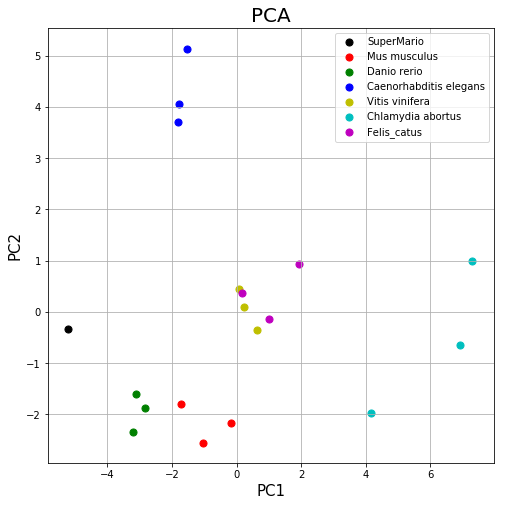

In [131]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)


organisms = [songname, 'Mus musculus', 'Danio rerio', 'Caenorhabditis elegans', 'Vitis vinifera', 'Chlamydia abortus', 'Felis_catus']
colors = ['k', 'r', 'g', 'b', 'y', 'c', 'm']

input_shapes = ['triangle', 'circle']
#shapes = [50,100]

for organism, color in zip(organisms,colors):
    indicesToKeep = final_df['organism'] == organism
    ax.scatter(final_df.loc[indicesToKeep, 'PC1']
               , final_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)

     
    
ax.legend(organisms)
ax.grid()

Saving and opening of PDF file with PCA graph

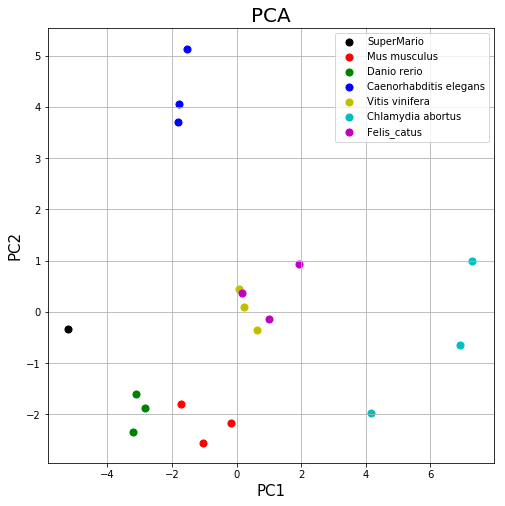

In [132]:
fig.savefig('PCA_music2DNA.png', bbox_inches='tight')

#import os
#dir_path = os.path.dirname(os.path.realpath('PCA_music2DNA.pdf'))
#print(dir_path)

#import webbrowser
#webbrowser.open_new(r'file:'+dir_path+'/PCA_music2DNA.pdf')

from IPython.display import Image

fig = Image(filename=('PCA_music2DNA.png'))
fig